# Synthetic Sonic Log Generation
###### Table of contents
1. [Introduction](#introduction)<br>
    1.1 [Background](#Background)<br>
    1.2 [Problem Statement](#Problem statement)<br>
    1.3 [Data Description](#Data Description)<br>
    1.4 [Evaluation Metric](#Evaluation Metric)<br>
2. [Import Data](#Import Data)<br>
3. [Exploratory Data Analysis](#Exploratory Data Analysis)
4. [Data Cleaning](#Data Cleaning)
5. [Build Machine Learning Models](#Build Machine Learning Models)

In [2]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from hyperopt import hp
from hyperopt import fmin, tpe, Trials, space_eval

from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import keras


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

import xgboost as xgb

import math
from numpy import linalg

from scipy.ndimage import median_filter
import warnings
warnings.filterwarnings('ignore')

C:\Program Files\Anaconda2\envs\mypython3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Introduction <a name="introduction"></a>
Introduction Section, taken as it is from the [Starter Notebook](https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Synthetic%20Sonic%20Log%20Generation%20Starter_Yu%202_27_2020.ipynb)

## 1.1. Background<a name="Background"></a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

## 1.2. Problem Statement<a name="Problem Statement"></a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation.

## 1.3. Data Decription<a name="Data Decription"></a>
> #### train.csv All the values equals to -999 are marked as missing values.

CAL - Caliper, unit in Inch,<br>
CNC - Neutron, unit in dec,<br>
GR - Gamma Ray, unit in API,<br>
HRD - Deep Resisitivity, unit in Ohm per meter,<br>
HRM - Medium Resistivity, unit in Ohm per meter,<br>
PE - Photo-electric Factor, unit in Barn,<br>
ZDEN - Density, unit in Gram per cubit meter,<b4>
DTC - Compressional Travel-time, unit in nanosecond per foot,<br>
DTS - Shear Travel-time, unit in nanosecond per foot,<br>
> #### test.csv The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

> #### sample_submission.csv A valid sample submission.

## 1.4. Evaluation Metric<a name="Evaluation Metric"></a>
We will be evaluated by the metirc Root Mean Squared Error.

The RMSE is calculated as:

$ ϵ=\sum_i \sqrt{ \sum_n (y_p - y_t)^2 /n } $

Where:

y_p is the predicted curve for DTC and DTS
y_t is the true value for evaluation.
DTC and DTS are in the same weight during the evaluation

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## 2. Import Data<a name="Import Data"></a>

In [18]:
file_path = './Data3_1_2020/'
#training dataset
df1 = pd.read_csv(file_path+'train.csv')
#test dataset
df2 = pd.read_csv(file_path+'test.csv')

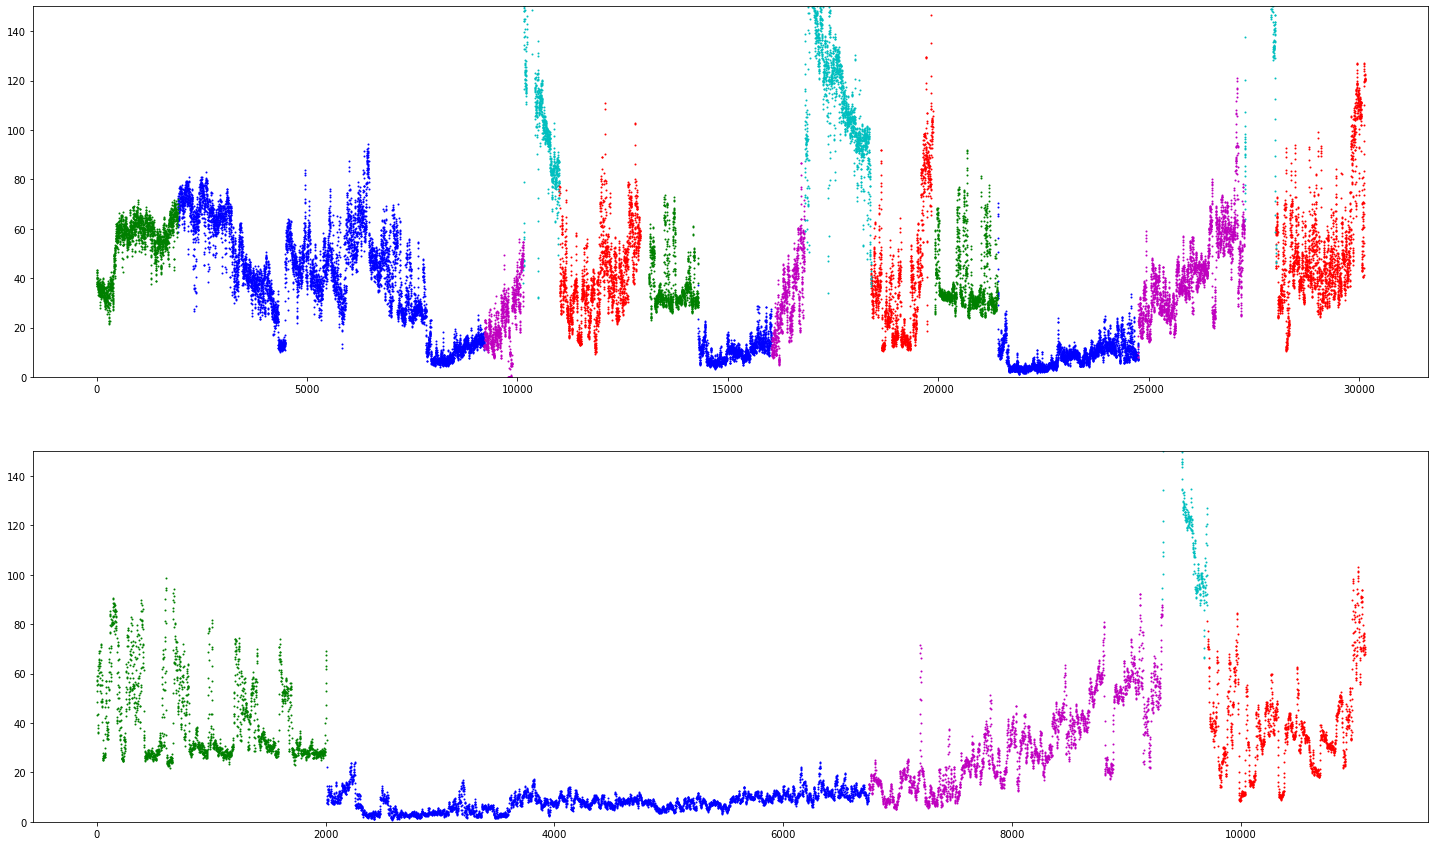

In [19]:
# Petrophysics-based zonation for both training and test set based on GR, ZDEN, CNC. Compared to test set,
# we found the training set showed similar spatial patterns, to take advantage of the spatial correlation
# we performed inter-well correlation. Per-zone estimation has been proved to be a good preprocessing method for well-log
# interpretation (Pan et al., in press; Pan et al., 2019)
df1['zone']=0
df1['zone'][13100:14297]=1;
df1['zone'][19890:21410]=1;
df1['zone'][:1925]=1;
#df1['zone'][1925:7000] no corresponding zone
#df1['zone'][7000:9210] DTS missing



df1['zone'][28022:]=2;
df1['zone'][18400:19888]=2;
df1['zone'][10993:12997]=2;

df1['zone'][27276:28022]=3;
df1['zone'][16823:18400]=3;
df1['zone'][10142:10993]=3;

df1['zone'][24753:27276]=4;
df1['zone'][16037:16823]=4;
df1['zone'][9210:10142]=4;

df2['zone']=0
df2['zone'][:2010]=1
df2['zone'][6749:9316]=4
df2['zone'][9316:9710]=3
df2['zone'][9710:]=2

co=['b','g','r','c','m','y']

# Figures show the patterns of gamma ray for different zones
fig, ax = plt.subplots(figsize = (25,15))
for i in range(6):  
    plt.subplot(2, 1, 1)
    plt.scatter(df1.index[df1.zone.values==i],df1.GR.values[df1.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])
    plt.subplot(2, 1, 2)
    plt.scatter(df2.index[df2.zone.values==i],df2.GR.values[df2.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])

In [20]:
df1.shape

(30143, 10)

In [21]:
df2.shape

(11088, 8)

In [22]:
df1.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS', 'zone']

In [23]:
df2.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'zone']

In [24]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,zone
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567,1.405102
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119,1.457198
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350,0.000000
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300,1.000000
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150,2.000000
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400,4.000000


Summary:
    In total, training data include 7 features and 2 targets. And test data have the same features as in the trainign dataset. 30143 entries of data were found in the training dataset.

## 3. Exploratory Data Analysis<a name="Exploratory Data Analysis"></a>

In [25]:
def plot_profile(data):
    plt.figure(figsize = (25,25))
    plt.title('Well Log Variable Profiles')
    y_tmp = range(data.shape[0])
    var = ['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD','DTC']
    scales = [[0,35],[-50, 250], [-0.15, 1], [1, 4], [-5,30], [0.2, 5], [30,500]]
    for i in range(len(var)):
        plt.subplot(171+i)
        plt.plot(var[i], y_tmp, data = data)
        plt.xlim(scales[i])
        plt.ylim([0,33000])
        if var[i] == 'HRD':
            plt.plot('HRM', y_tmp, data = data, c = 'red', label = 'HRM')
        elif var[i] == 'DTC':
            plt.plot('DTS', y_tmp, data = data, c = 'red', label = 'HRM')
        plt.gca().invert_yaxis()
        plt.title(var[i])

In [26]:
df1.tail()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,zone
30138,8.6719,0.1879,119.9486,2.5130,2.5187,0.0597,2.6240,74.2133,131.7747,2
30139,8.6719,0.1825,122.5286,2.5011,2.4818,0.0582,2.6194,74.3503,132.2201,2
30140,8.6797,0.1774,122.0544,2.5010,2.4717,0.0571,2.6169,74.4752,132.5171,2
30141,8.6719,0.1744,120.6518,2.5150,2.5007,0.0562,2.6159,74.5917,132.7115,2
30142,8.6719,0.1742,120.5270,2.5211,2.5068,0.0552,2.6155,74.7082,132.9060,2


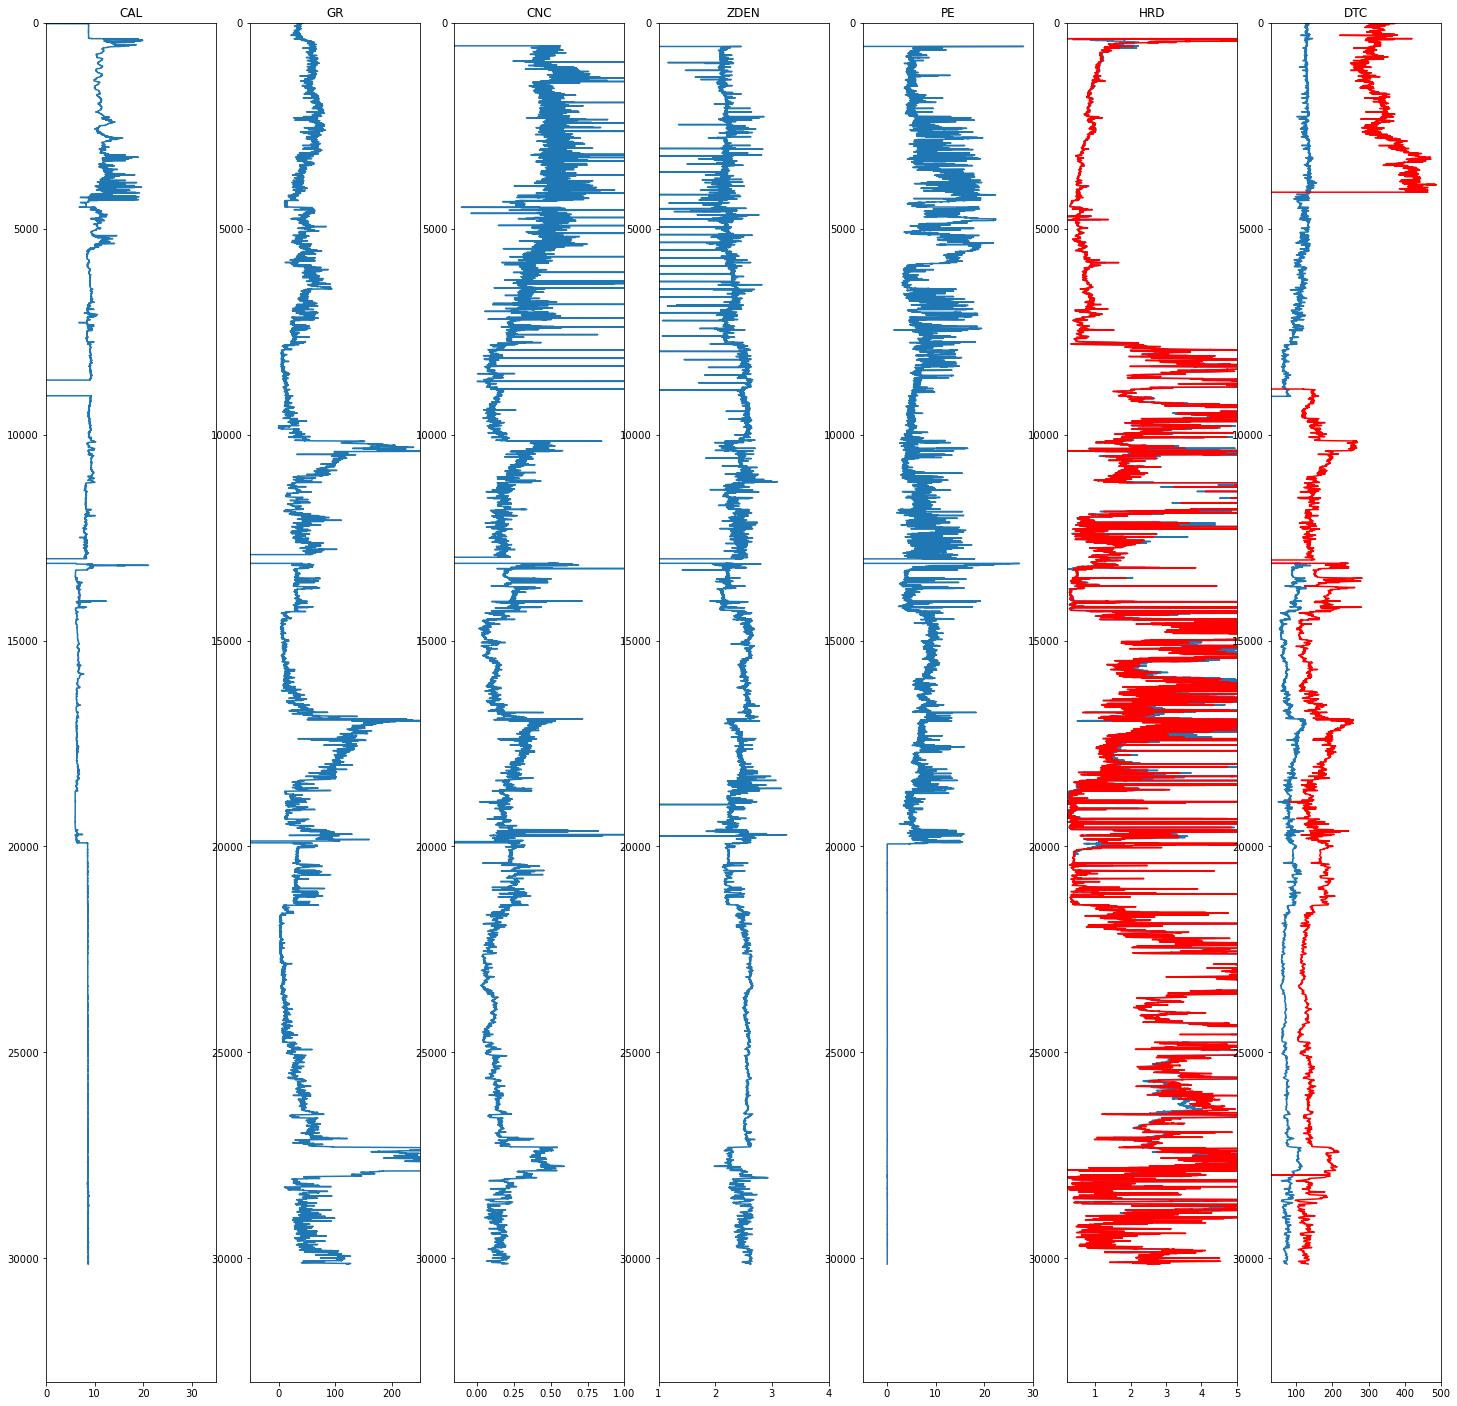

In [27]:
plot_profile(df1)

#### Summary of the profile plot 
CAL: In the range of depth index 0-5000, the data is not very stable.<br>
GR: Large values found at depth_index near 10000, 17000 and 27000.<br>
CNC: In the range of depth index 0-10000, the data variation is lager than the deeper .<br>
ZEN: Similar to CNC, in the range of 0-1000, data variation is slightly larger.<br>
PE: Suspicious value found below depth index 20000.<br>
HRD&HRM: The data variation is smaller at depth index range 0-7000.<br>
DTC&DTS: The DTS is clearly larger at depth index 0-5000.The ratio between DTC and DTS was quite similar in the deep.<br>

In [28]:
# Delete points where data are missing 
df1=df1[['CNC','GR','ZDEN','HRD','DTC','DTS','CAL','HRM','PE','zone']]
df1.replace(['-999', -999], np.nan, inplace=True)

df2=df2[['CNC','GR','ZDEN','HRD','CAL','HRM','PE','zone']]
df2.replace(['-999', -999], np.nan, inplace=True)

In [29]:
df1.isnull().sum()

CNC      735
GR       254
ZDEN     681
HRD      385
DTC     4054
DTS     4865
CAL      510
HRM      385
PE       679
zone       0
dtype: int64

In [30]:
df2.isnull().sum()

CNC     0
GR      0
ZDEN    0
HRD     0
CAL     0
HRM     0
PE      0
zone    0
dtype: int64

In [31]:
#delete the rows with nan value
df1.dropna(axis=0, inplace=True)
df2.dropna(axis=0, inplace=True)

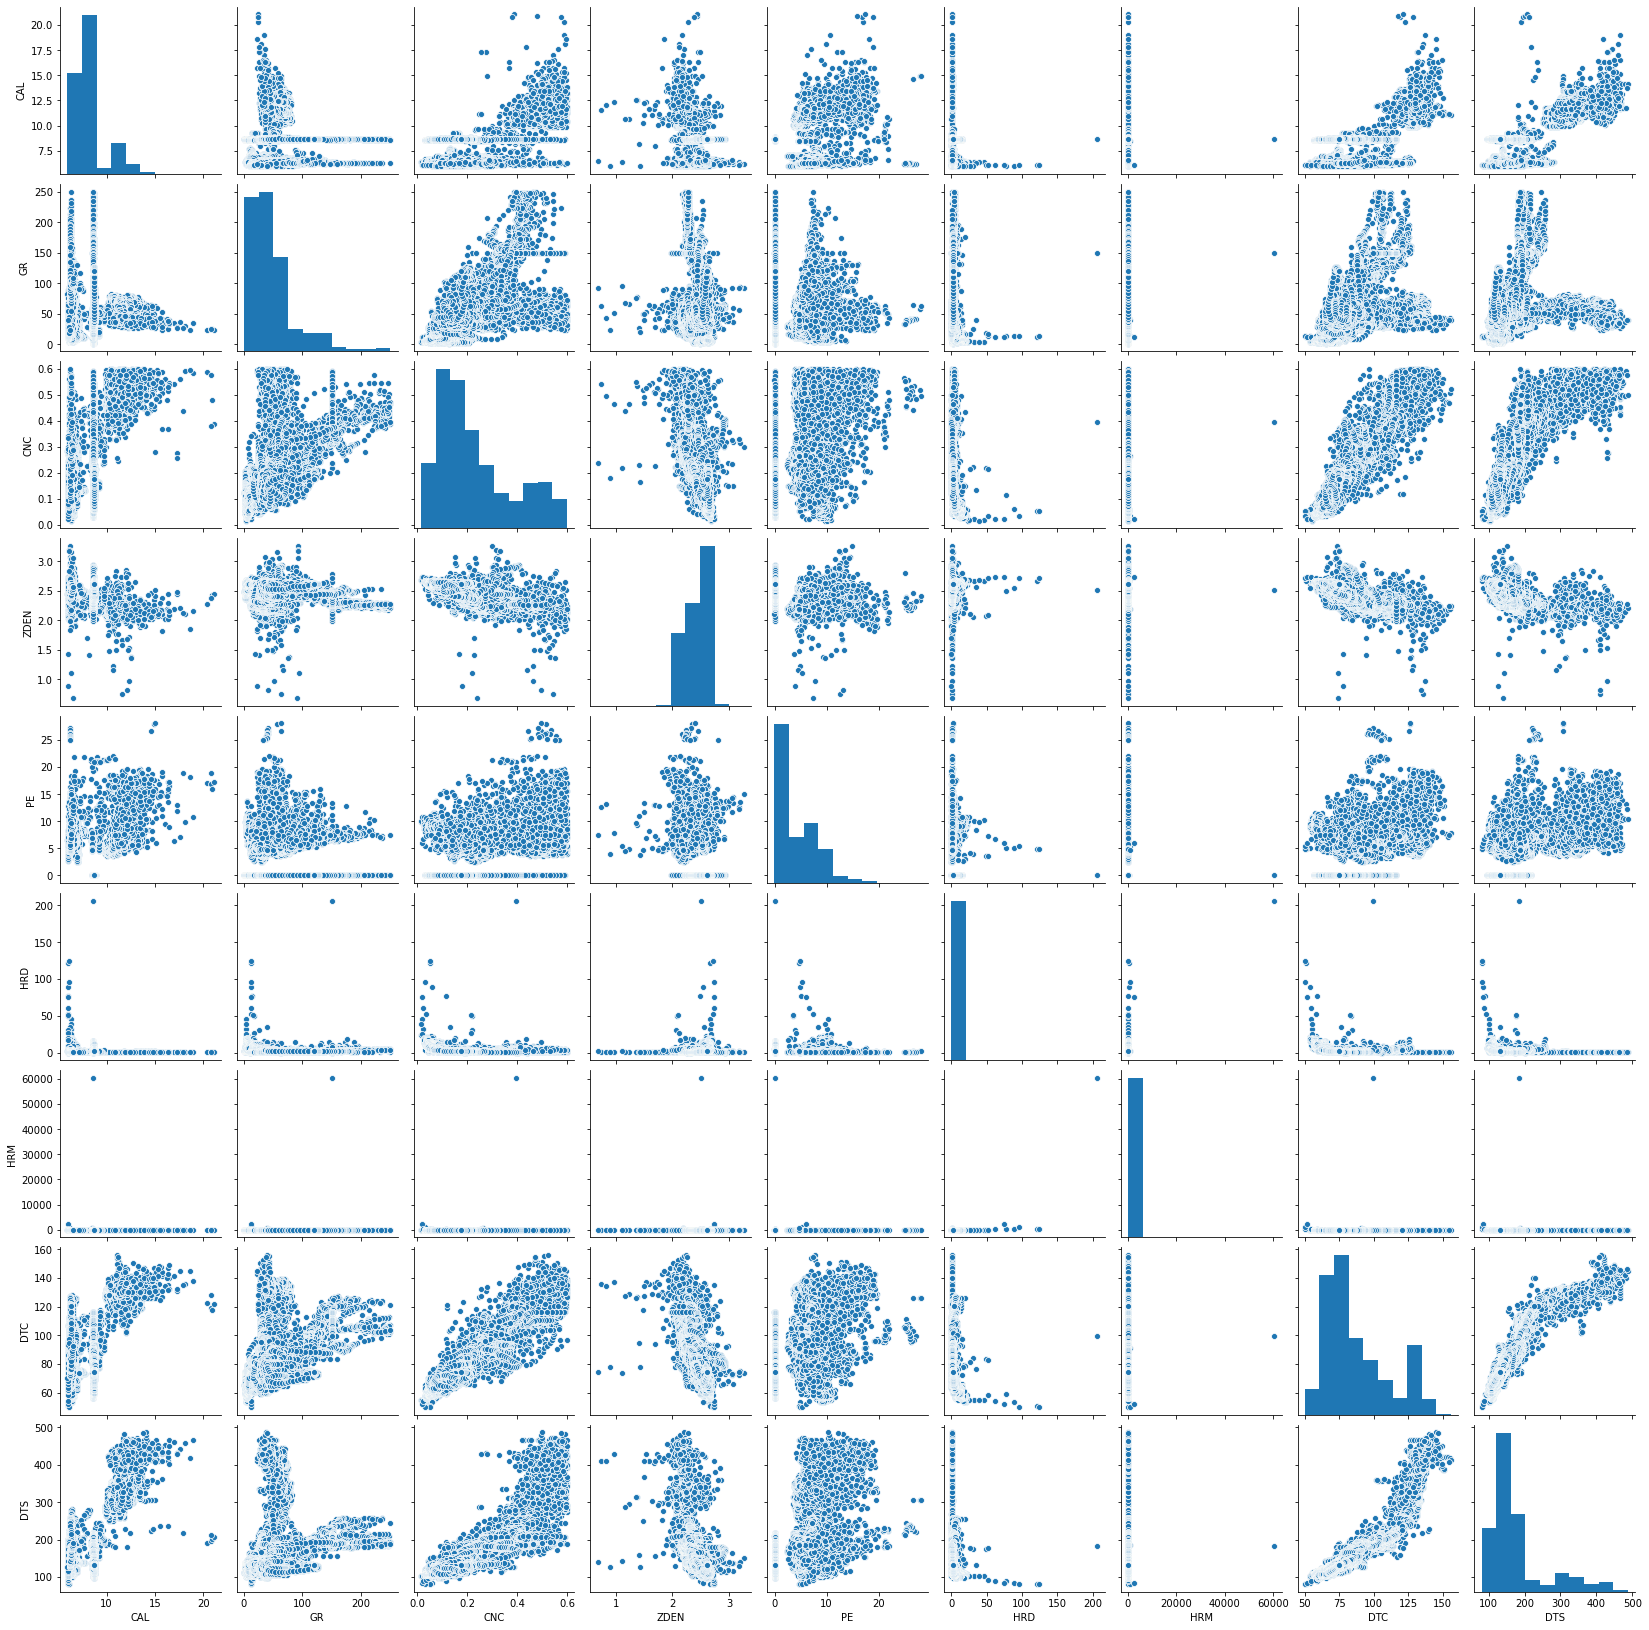

In [32]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
df_plot.dropna(axis=0, inplace=True)
g=sb.pairplot(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD','HRM','DTC','DTS']])

In [33]:
#Perform logrithmic transformation to resistivity logs to avoid large weight on resisitivity logs
df1['HRD_log']=np.log(df1.HRD.values)
df2['HRD_log']=np.log(df2.HRD.values)
df1['HRM_log']=np.log(df1.HRM.values)
df2['HRM_log']=np.log(df2.HRM.values)

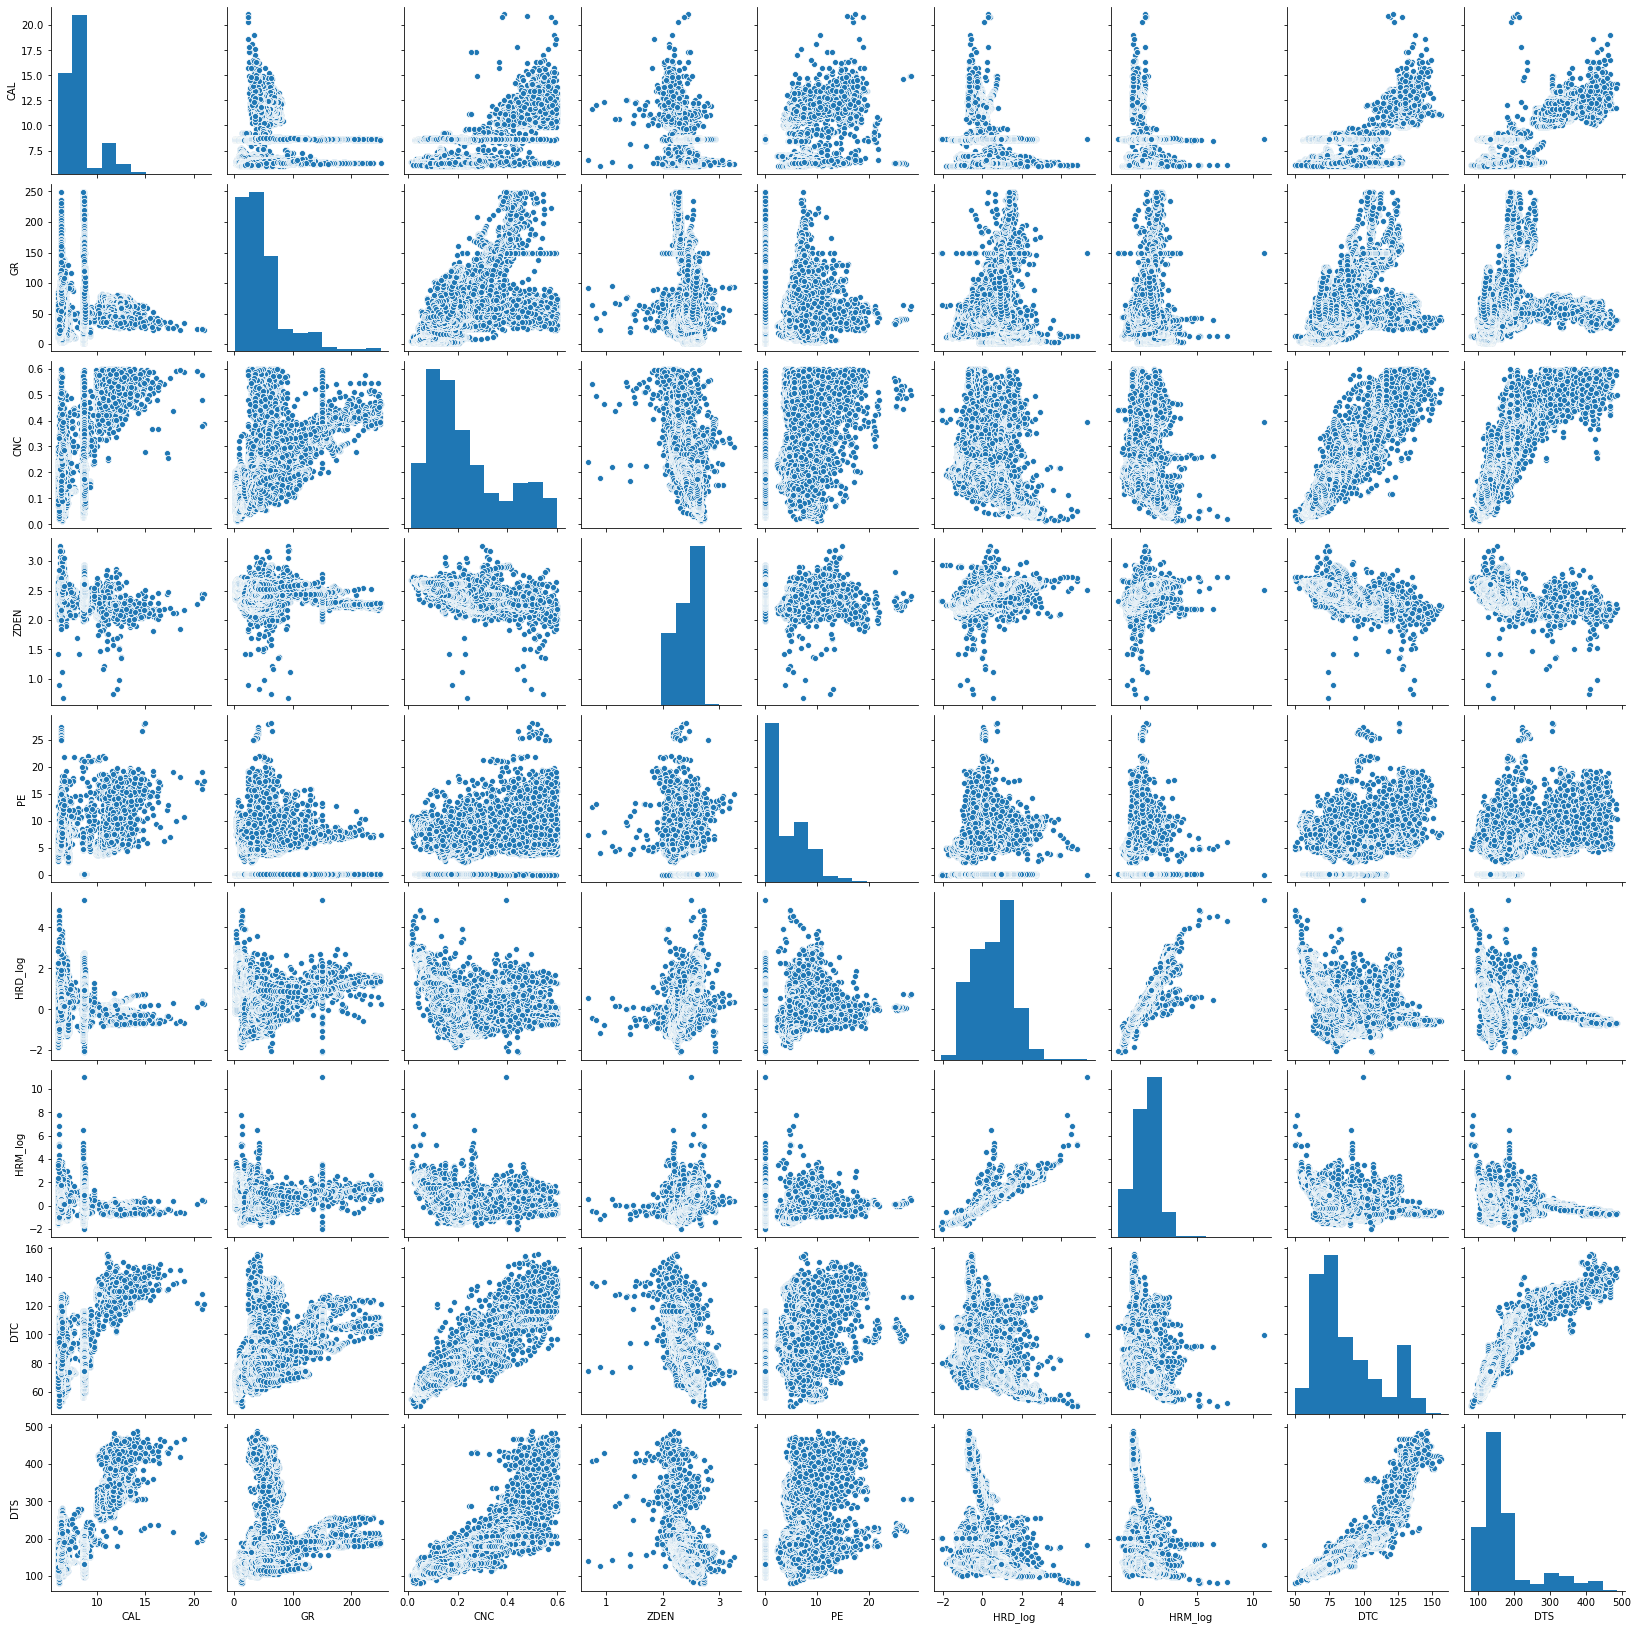

In [34]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
#df_plot['HRD_log'][df_plot['HRD_log']>150] = np.nan
#df_plot['HRM_log'][df_plot['HRM_log']>150] = np.nan
df_plot.dropna(axis=0, inplace=True)
g=sb.pairplot(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','DTC','DTS']])

### From the pair scatter plots we can found:
DTC and DTS are obviously correlated with CAL, GR, CNC<br>
Among the features, HRM and HRD are strongly correlated<br>
Some obcscure relationship can be observed between GR and CNC<br>

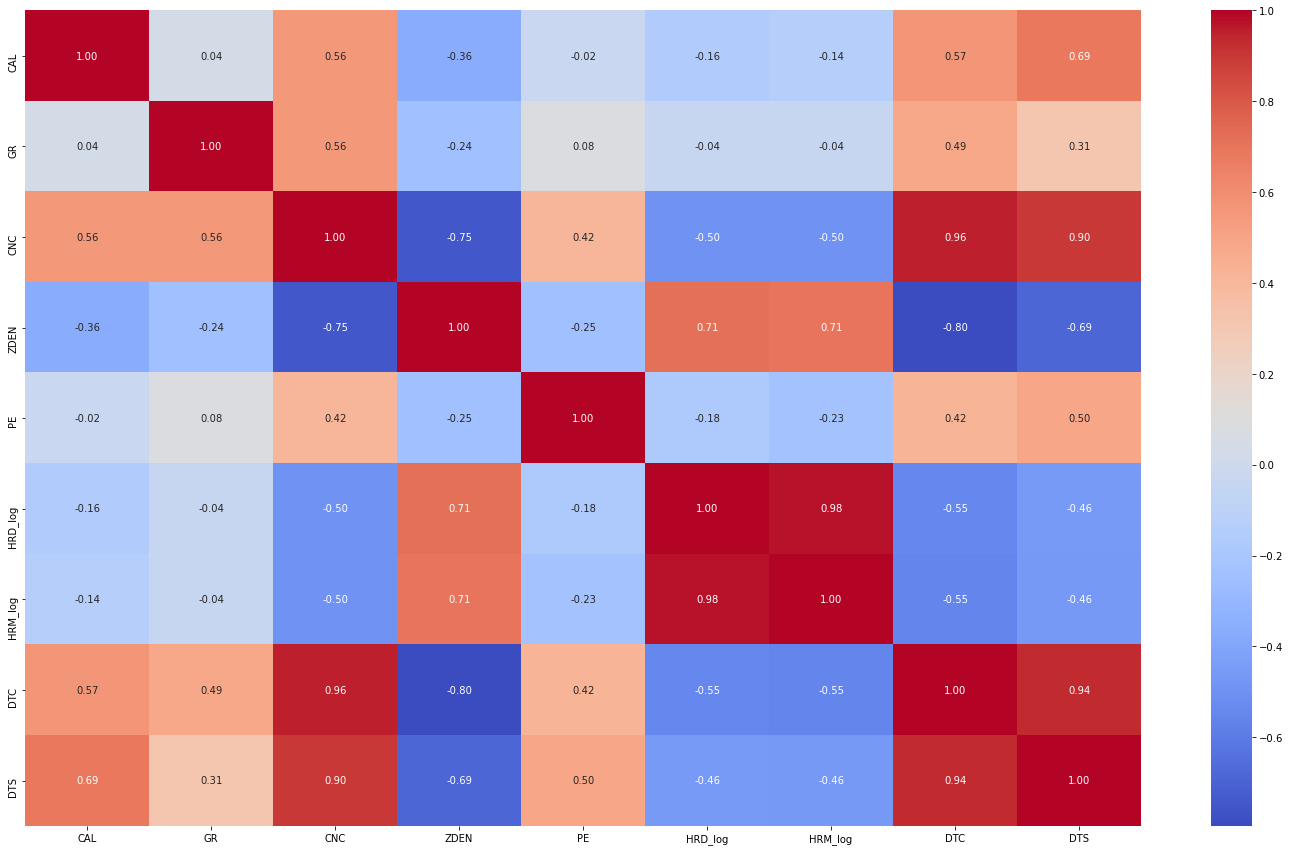

In [35]:
fig, ax = plt.subplots(figsize = (25,15))
cm_df = sb.heatmap(df_plot[['CAL','GR', 'CNC', 'ZDEN', 'PE', 'HRD_log','HRM_log','DTC','DTS']].corr(), annot = True, fmt = ".2f", cmap = 'coolwarm', ax = ax)

### Summary of correlation matrix 
CAL, CNC, ZDEN are strong indicators of the targes <br>
Similar to the observation from the paired plots, HRD and HRM are strongly correlated <br>
ZEN and CNC are negatively correlated <br>

## 4. Data Cleaning<a name="Data Cleaning"></a>

In [36]:
df2.describe()

,CNC,GR,ZDEN,HRD,CAL,HRM,PE,zone,HRD_log,HRM_log
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,0.158501,28.966414,2.475884,4.028372,8.634049,106.752210,7.353522,1.462482,0.931665,1.036167
std,0.091298,43.648163,0.149440,7.198112,0.044064,2374.620246,1.239075,1.601174,0.946956,1.105914
min,0.009800,0.852000,2.033400,0.083900,8.500000,0.102700,4.760800,0.000000,-2.478130,-2.275943
25%,0.091700,8.449450,2.378175,1.760775,8.625000,1.865575,6.528075,0.000000,0.565754,0.623569
50%,0.128300,18.168650,2.533600,2.758900,8.625000,3.176950,7.881700,1.000000,1.014832,1.155922
75%,0.213500,36.470725,2.581800,4.539675,8.671900,5.034600,8.308325,3.000000,1.512855,1.616334
max,0.559400,1124.442000,3.024800,202.233000,8.875000,62290.769500,13.840700,4.000000,5.309420,11.039569


In [37]:
df1.describe()

,CNC,GR,ZDEN,HRD,DTC,DTS,CAL,HRM,PE,zone,HRD_log,HRM_log
count,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,0.274416,49.889253,2.410734,2.598719,88.312221,182.051067,8.426679,5.835466,3.833792,1.529306,0.507259,0.522865
std,3.062495,54.811017,0.181713,3.465665,23.542419,84.670122,1.845912,422.449589,4.375818,1.467102,0.959167,0.975367
min,0.014500,1.038900,0.680600,0.123600,49.970500,80.580400,5.930400,0.134100,-0.023200,0.000000,-2.090705,-2.009169
25%,0.120300,16.036800,2.236100,0.810000,70.423100,127.148800,6.629100,0.797300,0.049800,0.000000,-0.210721,-0.226524
50%,0.187700,37.498000,2.466500,1.814900,79.695400,142.678500,8.578100,1.829300,3.287800,1.000000,0.596030,0.603933
75%,0.329000,61.140700,2.563700,3.337400,102.482800,192.757800,8.671900,3.463300,7.061300,3.000000,1.205192,1.242222
max,365.885000,1470.253400,3.259700,206.718200,155.980300,487.438400,21.064200,60467.761700,28.106400,4.000000,5.331357,11.009866


From the reference and test dataset statistics, we think the following should be applied to training dataset:<br>
CNC should range from 0.0 to 1.0<br>
GR should not have values less than 0.0<br>
PE should not have values less than 0.0<br>
ZDEN should not have values less than 0.0<br>

In [38]:
#Limit CNC to range between 0.0 and 1.0
df1['CNC'].loc[df1['CNC'] < 0] = np.nan
df1['CNC'].loc[df1['CNC'] > 1] = np.nan
#Limit PE to have values no less than 0.0
df1['PE'].loc[df1['PE']<0] = np.nan
df1['GR'].loc[df1['GR']>300] = np.nan
df1.dropna(axis=0, inplace=True)

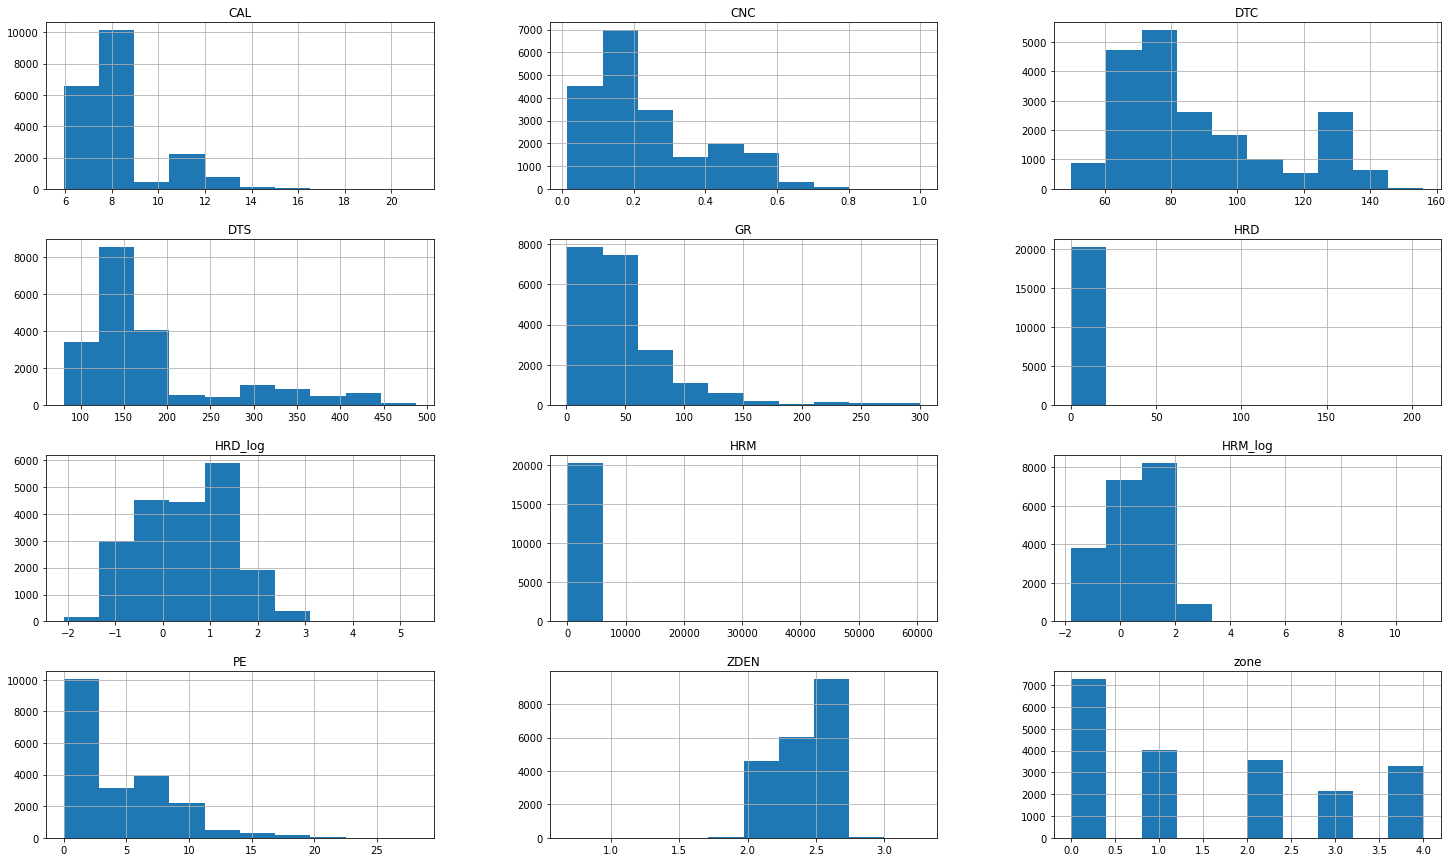

In [39]:
fig, ax = plt.subplots(figsize = (25,15))
hist = df1.hist(ax = ax)

## 5. Build Machine Learning Models<a name="Build Machine Learning Models"></a>

In [46]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.ylim([0,200])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.ylim([0,500])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [42]:
DTC2 = np.zeros(df2.shape[0])
DTS2 = np.zeros(df2.shape[0])

In [59]:
for iiii in [0,1,2,3,4]:
    for vel in ['DTC','DTS']:
        df=df1[df1.zone.values==iiii].copy()
        df_test=df2[df2.zone.values==iiii].copy()


        x=df[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CAL']].copy()
        y=df[[vel]].copy()
      
        scaler_X22 = StandardScaler()
        scaler_y22 = StandardScaler()
        x_train22 = scaler_X22.fit_transform(x.values)        
        y_train22 = scaler_y22.fit_transform(y.values)      

        #same operations are applied to test set.
        x_test=df_test[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CAL']].copy()#,'RM_log'
        x_test22=scaler_X22.transform(x_test.values)
       

        # gradient boosting model
        if vel == 'DTC':
            xgb22 = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.05, n_estimators=145, min_child_weight = 6, gamma = 0.3)
        else:
            xgb22 = xgb.XGBRegressor(random_state=42, max_depth=2,learning_rate=0.05, n_estimators=145, min_child_weight = 6, gamma = 0.3)    
        xgb22.fit(x_train22, y_train22)
        y_test22=xgb22.predict(x_test22)
        y_test22=scaler_y22.inverse_transform(y_test22)
        print(df_test.shape, y_test22.shape)
        if vel == 'DTC':
            DTC2[df2.zone.values==iiii]=y_test22
        elif vel == 'DTS':
            DTS2[df2.zone.values==iiii]=y_test22

(4739, 10) (4739,)
(4739, 10) (4739,)
(2010, 10) (2010,)
(2010, 10) (2010,)
(1378, 10) (1378,)
(1378, 10) (1378,)
(394, 10) (394,)
(394, 10) (394,)
(2567, 10) (2567,)
(2567, 10) (2567,)


In [60]:
y_predict_test22 = np.concatenate((DTC2.reshape(-1,1),DTS2.reshape(-1,1)),axis=1)

In [61]:
df2_y = pd.read_csv('real_test_result.csv')

Root Mean Square Error is: 15.20144


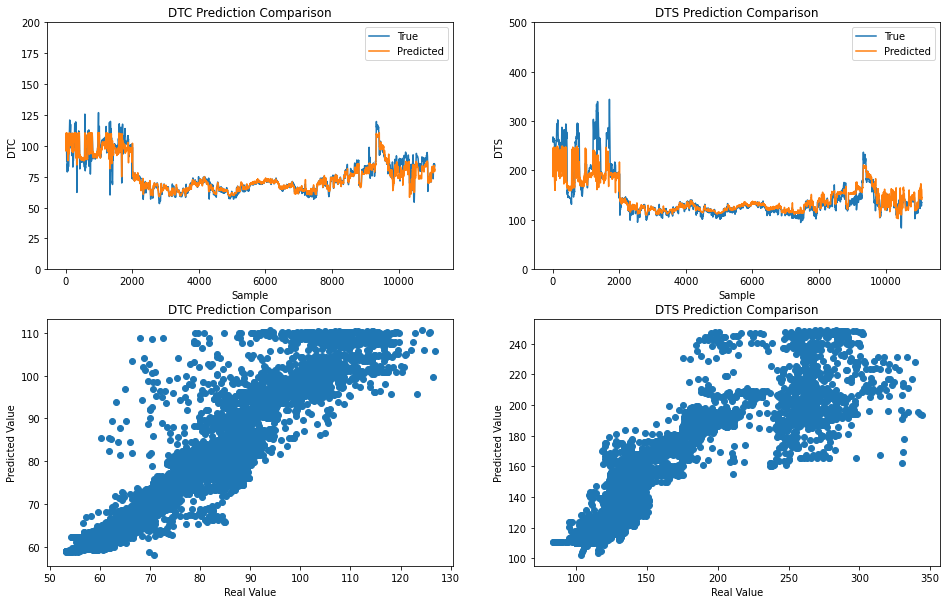

In [62]:
result_plot(y_predict_test22, df2_y.values)